# Data Exploration

## Humidity and Temperature Readings from Residencial Sensors

In [3]:
import pandas as pd
import datetime
import string
from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure
import numpy as np
import matplotlib.pyplot as plt

## Load Official Weather Data Observations

In [5]:

# parse the DWD dataset and convert date and align with home readings 
# Format dwd: yyyymmddhh
df = pd.read_csv('/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt', sep=';')

# parse date
df.insert(2, 'datetime', pd.to_datetime(df['MESS_DATUM'], errors='coerce', format='%Y%m%d%H'))

# create index
df.set_index('datetime', inplace=True)

# extract relevant columns and rename, subset
df.rename(columns={'TT_TU':'D_Temp','RF_TU':'D_Humi'}, inplace=True)

# filter years
filter = (df.index.year >= 2013) & (df.index.year <= 2016) 

# filter columns
df = df.loc[filter,['D_Temp', 'D_Humi']]

# resample
frequency = 'D'
df = df.resample(frequency).mean()

df.head()



,D_Temp,D_Humi
datetime,,
2013-01-01,6.658333,81.000000
2013-01-02,5.354167,83.541667
2013-01-03,7.995833,92.083333
2013-01-04,8.958333,92.458333
2013-01-05,7.554167,97.458333


# Load Home Sensor Observations

In [79]:
# read column headings
with open ('/Users/stewarta/repos/iot-htsensor/data/columns.txt') as f:
    cols = f.readlines()
cols = [ln.strip() for ln in cols] 

# read data from file: parse the date after reading, just as a sanity check
home = pd.read_csv('/Users/stewarta/Documents/DATA/htsensor/raw.data', sep = ';',decimal=',', names=cols)

#select relevant columns
home = home[['timestamp','Temp1', 'Temp2', 'Temp3', 'Temp4','Temp8','Humi1', 'Humi2', 'Humi3', 'Humi4']]

# index parse date and insert as new column
home.insert(1, 'datetime', pd.to_datetime(home.timestamp, errors='coerce')) # If ‘coerce’, then invalid parsing will be set as NaT

# set datetime index 
home.set_index('datetime', inplace=True)

# bit of clean up
home.drop(columns='timestamp', inplace=True)

# resample
home = home.resample(frequency).mean()
home.head()

,Temp1,Temp2,Temp3,Temp4,Temp8,Humi1,Humi2,Humi3,Humi4
datetime,,,,,,,,,
2013-04-14,15.696051,19.860450,23.692588,20.733840,16.897813,70.401580,47.047995,37.205954,44.666464
2013-04-15,17.653432,20.365598,21.085450,21.015988,16.734402,65.504316,50.438142,47.623510,47.817509
2013-04-16,16.500497,20.450207,20.310927,21.164996,15.867508,66.577815,50.214404,50.812500,48.237365
2013-04-17,16.010161,20.236791,19.731583,20.912616,15.809272,64.488569,49.231160,50.230737,47.296359
2013-04-18,17.064194,20.245818,20.180305,21.182530,15.878121,53.960445,44.769674,44.257520,43.027606


## Outside Data : Visual Inspection

In [6]:
# Temperature Sensor 1: Overview
col = 'D_Temp'

dates = df.index.values
source = ColumnDataSource(data=dict(date=dates, close=df[col]))

p = figure(title="Official Outdoor Temperature Observations Braunschweig (City Center) Germany (2013 - 2016)",
           plot_height=300, plot_width=800, tools="", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[0], dates[df[col].shape[0]-1]))

p.line('date', 'close', source=source)
p.yaxis.axis_label = 'Celcius'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', 'close', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

show(column(p, select))

## Locate Outlier

In [81]:
# determine date of the outlier
df.loc[df['D_Temp'] < -10]

,D_Temp,D_Humi
datetime,,
2014-03-10,-44.277778,-4.444444


## Locate Missing Value

In [82]:
df.loc[pd.isnull(df[['D_Temp']]).any(1)]

,D_Temp,D_Humi
datetime,,
2014-03-09,NaN,NaN


## Manually Correct Errors for Two Days 
Only two values so, manually correct using online lookup 
https://latin.wunderground.com/history/airport/EDVE/2018/4/2/DailyHistory.html

In [83]:
df.loc['2014-03-09':'2014-03-10','D_Temp'] = [10,10]
df.loc['2014-03-09':'2014-03-10','D_Humi'] = [57,52]
df.loc['2014-03-09':'2014-03-10',['D_Temp', 'D_Humi']] 

,D_Temp,D_Humi
datetime,,
2014-03-09,10.0,57.0
2014-03-10,10.0,52.0


In [ ]:
## Decompose Series

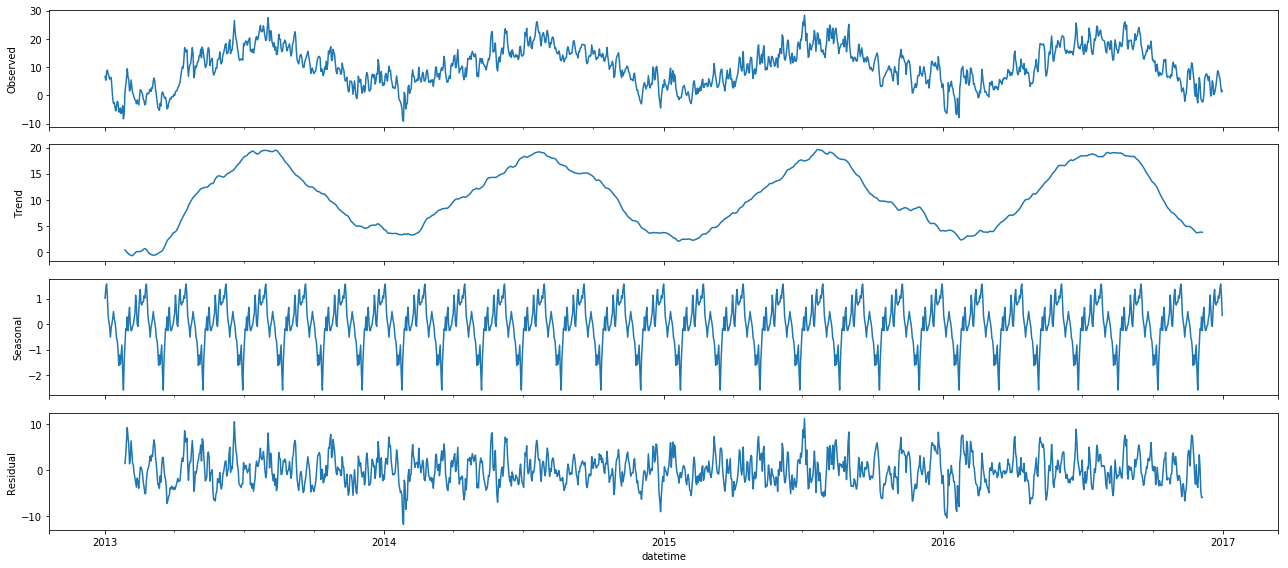

In [84]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df['D_Temp'], freq=52 , model='additive')
fig = decomposition.plot()
plt.show()

## Inside Data: Visual Inspection
### Q: Which Sensor do you think was located outside in 2013?

In [96]:
col = 'Temp1'

dates = home.index.values
source = ColumnDataSource(data=dict(date=dates, close=home[col]))

p = figure(title="Home Temperature Observations Braunschweig (City Center) Germany (2013 - 2016)",
           plot_height=300, plot_width=800, tools="", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[0], dates[home[col].shape[0]-1]))

p.line('date', 'close', source=source)
p.yaxis.axis_label = 'Celcius'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', 'close', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

show(column(p, select))

## Interpolate the missing values 

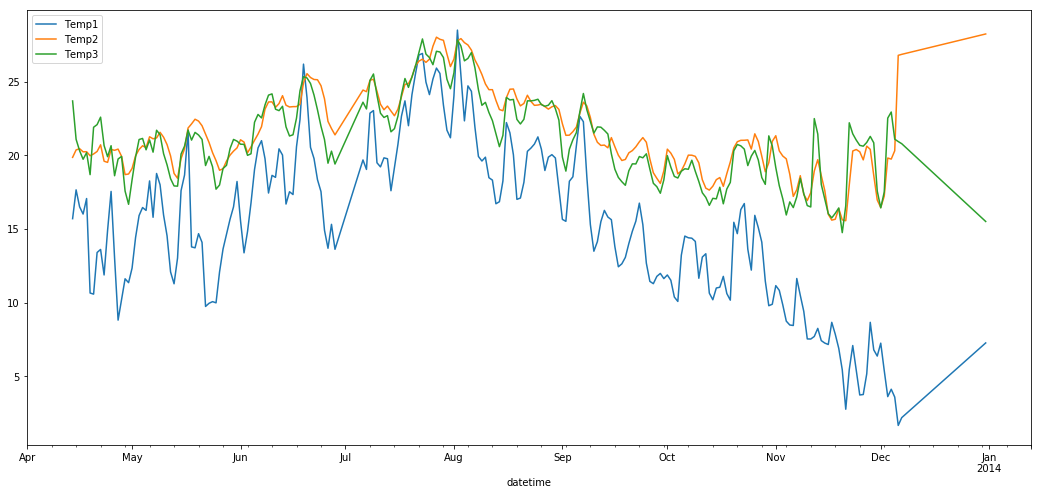

In [43]:
int_home = df.interpolate()
int_home.loc[df.index.year==2013,['Temp1','Temp2','Temp3']].plot()

In [53]:
rcParams['figure.figsize'] = 18, 8

home = int_home.loc[int_home.index.year==2013,['Temp3']]
decomposition = sm.tsa.seasonal_decompose(home, freq=12 , model='additive')
fig = decomposition.plot()
plt.show()

ValueError: This function does not handle missing values

## Conclusion:

Pretty Cool:  temparture reading collected with devices in my home overlay quite nicely with the official data from German Wetterdeinst (DWD). Since my data has missing values due to relocation and downtime we can use DWD to interpolate missing values in my own data set.

In [95]:
# overlay a sample of the Germany weather data with the home reading.

filter = (df.index.year == 2013) & (df.index.month == 4)
x = np.array(df[filter].index)
y = np.array(df[filter]['Temp1'])
y1 = np.array(df[filter]['D_Temp'])
fig, ax = plt.subplots()
ax.set_title('Overlay Germany Weather Data April, 2013')
ax.plot(x, y, 'black', label = 'home sensor')
ax.plot(x, y1, '.', label='weather svc.', color = 'red')
fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Celcius')
ax.legend(loc='best')

KeyError: 'Temp1'